# Multiple Linear Regression Model

This notebook trains a multiple linear regression model for housing price prediction, following Week 4 requirements:
- Train/Val/Test Split
- Define Target
- Train Model
- Evaluate Model (RMSE on validation set)

**Note:** This notebook uses the preprocessed features from Section 7 of `eda_notebook.ipynb`.


## 1. Setup and Imports


In [103]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import joblib
import json
import os
import warnings
warnings.filterwarnings('ignore')

# Set style for plots
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)

print("Libraries imported successfully!")


Libraries imported successfully!


## 2. Load Preprocessed Data from EDA Notebook


In [104]:
# Load preprocessed data from saved files
# Note: Run Section 7 of eda_notebook.ipynb first to generate these saved files
import os
import joblib
import json

print("=" * 80)
print("LOADING PREPROCESSED DATA")
print("=" * 80)

if not os.path.exists('saved_data/X_preprocessed.csv'):
    raise FileNotFoundError(
        "\n⚠ Error: Preprocessed data files not found!\n"
        "Please run Section 7 of eda_notebook.ipynb first to generate the saved data files.\n"
        "The saved files should be in the 'saved_data/' directory."
    )

print("\nLoading preprocessed data from saved files...")
X = pd.read_csv('saved_data/X_preprocessed.csv', index_col=0)  # Preserve index
y = pd.read_csv('saved_data/y_preprocessed.csv', index_col=0).squeeze()  # Preserve index, convert to Series
scaler = joblib.load('saved_data/scaler.pkl')
with open('saved_data/feature_names.json', 'r') as f:
    all_features_to_use = json.load(f)

print("✓ Preprocessed data loaded successfully!")
print(f"  • Feature matrix: {X.shape}")
print(f"  • Target variable: {y.shape}")
print(f"  • Scaler: {type(scaler).__name__}")
print(f"  • Feature names: {len(all_features_to_use)} features")
print(f"  • Index preserved: {X.index.min()} to {X.index.max()}")


LOADING PREPROCESSED DATA

Loading preprocessed data from saved files...
✓ Preprocessed data loaded successfully!
  • Feature matrix: (1460, 17)
  • Target variable: (1460,)
  • Scaler: StandardScaler
  • Feature names: 17 features
  • Index preserved: 0 to 1459


In [105]:
# Verify that X and y are available
if 'X' not in globals() or 'y' not in globals():
    print("⚠ Error: X and y not found after loading.")
    print("Please ensure:")
    print("  1. Section 7 of eda_notebook.ipynb has been run (to create saved_data/ folder)")
    print("  2. Or saved_data/ folder exists with preprocessed data files")
    raise ValueError("Preprocessed data (X, y) not available. Please run Section 7 of eda_notebook.ipynb first.")

print("=" * 80)
print("DATA VERIFICATION")
print("=" * 80)
print(f"\n✓ Preprocessed data loaded successfully!")
print(f"Feature matrix (X) shape: {X.shape}")
print(f"Target variable (y) shape: {y.shape}")
print(f"Number of features: {X.shape[1]}")
print(f"Number of samples: {X.shape[0]}")

if 'all_features_to_use' in globals():
    print(f"Feature names available: {len(all_features_to_use)} features")
if 'scaler' in globals():
    print(f"Scaler available: {type(scaler).__name__}")

# Check for missing values
missing_X = X.isnull().sum().sum()
missing_y = y.isnull().sum()

if missing_X > 0:
    print(f"\n⚠ Warning: {missing_X} missing values in feature matrix")
else:
    print(f"\n✓ No missing values in feature matrix")

if missing_y > 0:
    print(f"⚠ Warning: {missing_y} missing values in target variable")
else:
    print(f"✓ No missing values in target variable")


DATA VERIFICATION

✓ Preprocessed data loaded successfully!
Feature matrix (X) shape: (1460, 17)
Target variable (y) shape: (1460,)
Number of features: 17
Number of samples: 1460
Feature names available: 17 features
Scaler available: StandardScaler

✓ No missing values in feature matrix
✓ No missing values in target variable


## 3. Train/Val/Test Split


In [106]:
# Load split indices from EDA notebook (ensures all models use the same splits)
print("=" * 80)
print("LOADING TRAIN/VAL/TEST SPLIT INDICES")
print("=" * 80)

if not os.path.exists('saved_data/split_indices.json'):
    raise FileNotFoundError(
        "\n⚠ Error: Split indices file not found!\n"
        "Please run Section 7 of eda_notebook.ipynb first to generate the split indices.\n"
        "The file should be in 'saved_data/split_indices.json'."
    )

# Load split indices
with open('saved_data/split_indices.json', 'r') as f:
    split_indices = json.load(f)

print(f"\n✓ Split indices loaded from saved_data/split_indices.json")
print(f"  Random state used: {split_indices['random_state']}")

# Use the saved indices to create splits
train_idx = split_indices['train']
val_idx = split_indices['val']
test_idx = split_indices['test']

# Create splits using the saved indices (indices match the original dataframe)
X_train = X.loc[train_idx].copy()
X_val = X.loc[val_idx].copy()
X_test = X.loc[test_idx].copy()

y_train = y.loc[train_idx].copy()
y_val = y.loc[val_idx].copy()
y_test = y.loc[test_idx].copy()

# Reset index for cleaner dataframes (optional, but keeps indices sequential)
X_train = X_train.reset_index(drop=True)
X_val = X_val.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)

y_train = y_train.reset_index(drop=True)
y_val = y_val.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

print("\n" + "=" * 80)
print("TRAIN/VAL/TEST SPLIT COMPLETE")
print("=" * 80)
print(f"\nTraining set:")
print(f"  X_train shape: {X_train.shape}")
print(f"  y_train shape: {y_train.shape}")
print(f"  Percentage: {len(X_train) / len(X) * 100:.1f}%")

print(f"\nValidation set:")
print(f"  X_val shape: {X_val.shape}")
print(f"  y_val shape: {y_val.shape}")
print(f"  Percentage: {len(X_val) / len(X) * 100:.1f}%")

print(f"\nTest set:")
print(f"  X_test shape: {X_test.shape}")
print(f"  y_test shape: {y_test.shape}")
print(f"  Percentage: {len(X_test) / len(X) * 100:.1f}%")

print(f"\nTotal samples: {len(X)}")
print(f"Split verification: {len(X_train) + len(X_val) + len(X_test)} = {len(X)} ✓")
print(f"\n✓ Using same splits as all other model notebooks (for fair comparison)")


LOADING TRAIN/VAL/TEST SPLIT INDICES

✓ Split indices loaded from saved_data/split_indices.json
  Random state used: 42

TRAIN/VAL/TEST SPLIT COMPLETE

Training set:
  X_train shape: (876, 17)
  y_train shape: (876,)
  Percentage: 60.0%

Validation set:
  X_val shape: (292, 17)
  y_val shape: (292,)
  Percentage: 20.0%

Test set:
  X_test shape: (292, 17)
  y_test shape: (292,)
  Percentage: 20.0%

Total samples: 1460
Split verification: 1460 = 1460 ✓

✓ Using same splits as all other model notebooks (for fair comparison)


## 4. Define Target Variable


In [107]:
# Verify target variable is correctly set
print("=" * 80)
print("TARGET VARIABLE VERIFICATION")
print("=" * 80)

print(f"\nTarget variable: LogSalePrice (log-transformed SalePrice)")
print(f"Target shape: {y.shape}")
print(f"Target data type: {y.dtype}")

# Check target statistics
print(f"\nTarget variable statistics:")
print(f"  Mean: {y.mean():.4f}")
print(f"  Median: {y.median():.4f}")
print(f"  Std Dev: {y.std():.4f}")
print(f"  Min: {y.min():.4f}")
print(f"  Max: {y.max():.4f}")

# Check for missing values
missing_y = y.isnull().sum()
if missing_y > 0:
    print(f"\n⚠ Warning: {missing_y} missing values in target variable")
    # Handle missing values if any
    y = y.dropna()
    X = X.loc[y.index]
    print(f"Removed rows with missing target values")
else:
    print(f"\n✓ No missing values in target variable")

print(f"\n✓ Target variable is ready for modeling")


TARGET VARIABLE VERIFICATION

Target variable: LogSalePrice (log-transformed SalePrice)
Target shape: (1460,)
Target data type: float64

Target variable statistics:
  Mean: 12.0241
  Median: 12.0015
  Std Dev: 0.3994
  Min: 10.4603
  Max: 13.5345

✓ No missing values in target variable

✓ Target variable is ready for modeling


## 5. Train Linear Regression Model


In [108]:
# Initialize and train the linear regression model
print("=" * 80)
print("TRAINING LINEAR REGRESSION MODEL")
print("=" * 80)

# Initialize model
model = LinearRegression()

# Fit model on training data
print("\nFitting model on training data...")
model.fit(X_train, y_train)

print("✓ Model training complete!")

# Print model parameters
print(f"\nModel Parameters:")
print(f"  Intercept: {model.intercept_:.6f}")
print(f"  Number of coefficients: {len(model.coef_)}")

# Show top 10 features by absolute coefficient value
if 'all_features_to_use' in globals():
    feature_names = all_features_to_use
else:
    feature_names = [f'Feature_{i}' for i in range(len(model.coef_))]

coef_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': model.coef_
})
coef_df['Abs_Coefficient'] = np.abs(coef_df['Coefficient'])
coef_df = coef_df.sort_values('Abs_Coefficient', ascending=False)

print(f"\nTop 10 Features by Absolute Coefficient:")
print("-" * 80)
for idx, row in coef_df.head(10).iterrows():
    print(f"{row['Feature']:<30} Coefficient: {row['Coefficient']:>10.6f}")


TRAINING LINEAR REGRESSION MODEL

Fitting model on training data...
✓ Model training complete!

Model Parameters:
  Intercept: 12.025512
  Number of coefficients: 17

Top 10 Features by Absolute Coefficient:
--------------------------------------------------------------------------------
OverallQual                    Coefficient:   0.126727
TotalSF                        Coefficient:   0.081223
GarageCars                     Coefficient:   0.062456
TotRmsAbvGrd                   Coefficient:   0.046537
CentralAir                     Coefficient:   0.038726
BsmtFinType1                   Coefficient:  -0.037998
AgeSinceRemodel                Coefficient:  -0.033719
GarageType                     Coefficient:  -0.029633
BsmtQual                       Coefficient:  -0.024279
KitchenQual                    Coefficient:  -0.022902


## 6. Model Evaluation


In [109]:
# Make predictions on training and validation sets
print("=" * 80)
print("MODEL EVALUATION")
print("=" * 80)

# Predictions
y_train_pred = model.predict(X_train)
y_val_pred = model.predict(X_val)

# Calculate RMSE (Root Mean Squared Error)
# Use np.sqrt for compatibility with older sklearn versions
rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
rmse_val = np.sqrt(mean_squared_error(y_val, y_val_pred))

# Calculate R² score
r2_train = r2_score(y_train, y_train_pred)
r2_val = r2_score(y_val, y_val_pred)

# Calculate MAE (Mean Absolute Error)
mae_train = mean_absolute_error(y_train, y_train_pred)
mae_val = mean_absolute_error(y_val, y_val_pred)

# Print evaluation metrics
print(f"\nEvaluation Metrics:")
print("-" * 80)
print(f"{'Metric':<20} {'Training':<15} {'Validation':<15}")
print("-" * 80)
print(f"{'RMSE':<20} {rmse_train:<15.6f} {rmse_val:<15.6f}")
print(f"{'R² Score':<20} {r2_train:<15.6f} {r2_val:<15.6f}")
print(f"{'MAE':<20} {mae_train:<15.6f} {mae_val:<15.6f}")

# Check for overfitting
print(f"\nOverfitting Analysis:")
print("-" * 80)
rmse_diff = rmse_val - rmse_train
r2_diff = r2_train - r2_val

print(f"RMSE difference (val - train): {rmse_diff:.6f}")
print(f"R² difference (train - val): {r2_diff:.6f}")

if rmse_diff > 0.1 or r2_diff > 0.1:
    print("⚠ Warning: Potential overfitting detected (large gap between train and validation performance)")
else:
    print("✓ Model shows good generalization (train and validation performance are similar)")


MODEL EVALUATION

Evaluation Metrics:
--------------------------------------------------------------------------------
Metric               Training        Validation     
--------------------------------------------------------------------------------
RMSE                 0.160061        0.158748       
R² Score             0.831393        0.836267       
MAE                  0.110367        0.110581       

Overfitting Analysis:
--------------------------------------------------------------------------------
RMSE difference (val - train): -0.001313
R² difference (train - val): -0.004874
✓ Model shows good generalization (train and validation performance are similar)


### 6.1 Visualization: Predictions vs Actual Values


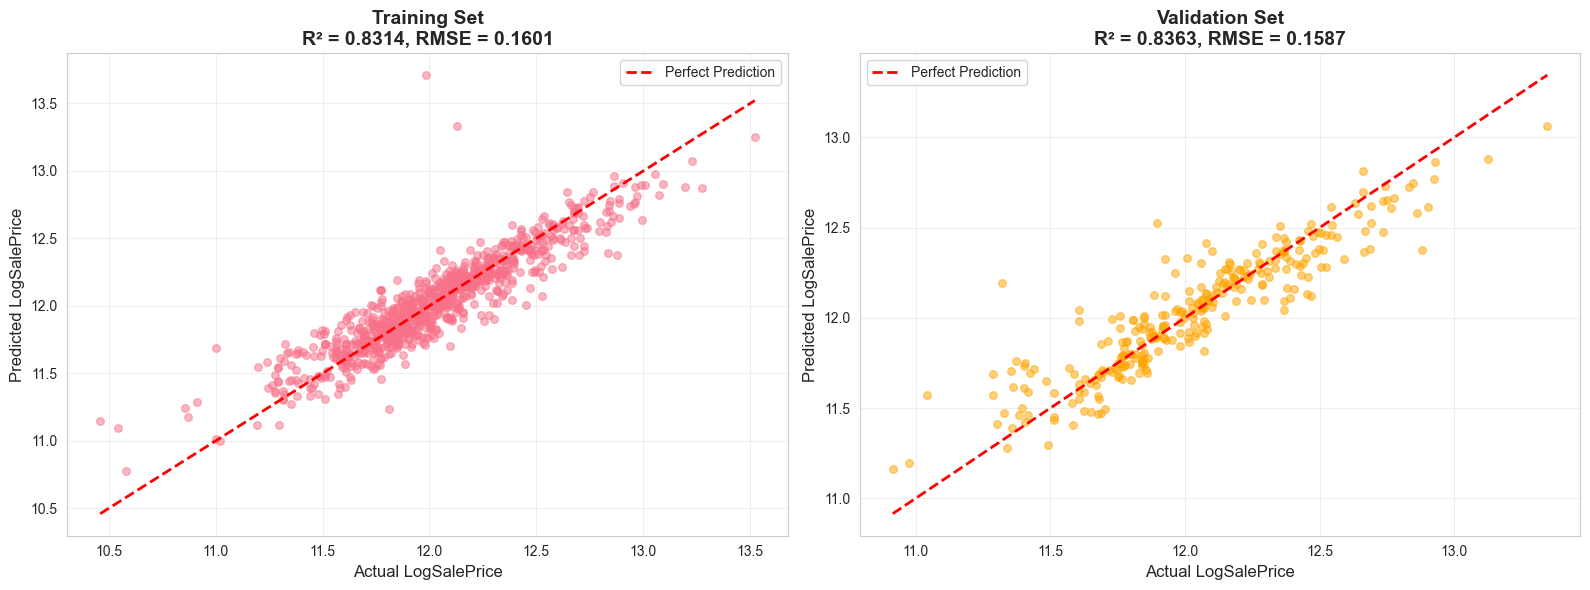


Interpretation:
- Points closer to the red diagonal line indicate better predictions
- R² score measures how well the model explains the variance
- RMSE measures the average prediction error


In [110]:
# Create scatter plots: Predictions vs Actual
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Training set
axes[0].scatter(y_train, y_train_pred, alpha=0.5, s=30)
axes[0].plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 
             'r--', linewidth=2, label='Perfect Prediction')
axes[0].set_xlabel('Actual LogSalePrice', fontsize=12)
axes[0].set_ylabel('Predicted LogSalePrice', fontsize=12)
axes[0].set_title(f'Training Set\nR² = {r2_train:.4f}, RMSE = {rmse_train:.4f}', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Validation set
axes[1].scatter(y_val, y_val_pred, alpha=0.5, s=30, color='orange')
axes[1].plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 
             'r--', linewidth=2, label='Perfect Prediction')
axes[1].set_xlabel('Actual LogSalePrice', fontsize=12)
axes[1].set_ylabel('Predicted LogSalePrice', fontsize=12)
axes[1].set_title(f'Validation Set\nR² = {r2_val:.4f}, RMSE = {rmse_val:.4f}', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nInterpretation:")
print("- Points closer to the red diagonal line indicate better predictions")
print("- R² score measures how well the model explains the variance")
print("- RMSE measures the average prediction error")


### 6.2 Visualization: Residual Plots


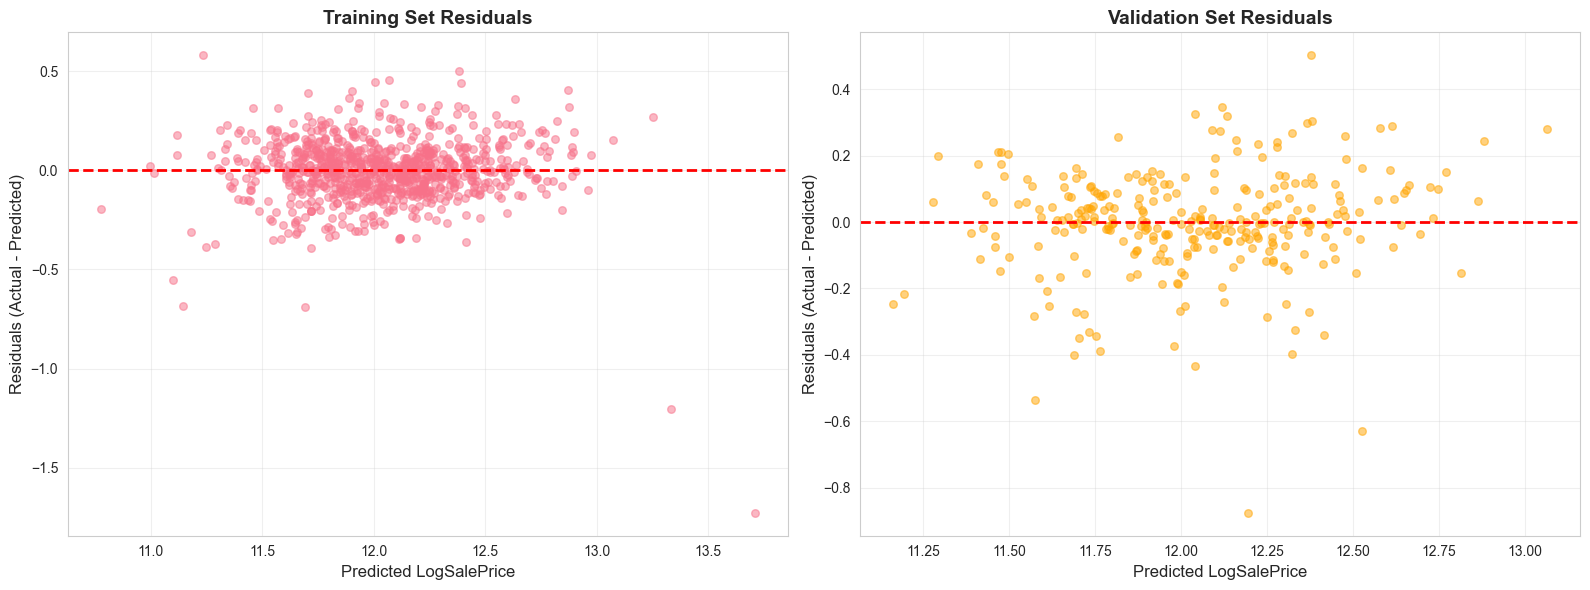


Interpretation:
- Residuals should be randomly distributed around zero
- No clear patterns indicate good model fit
- Fan-shaped patterns suggest heteroscedasticity (non-constant variance)


In [111]:
# Create residual plots
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Calculate residuals
residuals_train = y_train - y_train_pred
residuals_val = y_val - y_val_pred

# Training set residuals
axes[0].scatter(y_train_pred, residuals_train, alpha=0.5, s=30)
axes[0].axhline(y=0, color='r', linestyle='--', linewidth=2)
axes[0].set_xlabel('Predicted LogSalePrice', fontsize=12)
axes[0].set_ylabel('Residuals (Actual - Predicted)', fontsize=12)
axes[0].set_title('Training Set Residuals', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3)

# Validation set residuals
axes[1].scatter(y_val_pred, residuals_val, alpha=0.5, s=30, color='orange')
axes[1].axhline(y=0, color='r', linestyle='--', linewidth=2)
axes[1].set_xlabel('Predicted LogSalePrice', fontsize=12)
axes[1].set_ylabel('Residuals (Actual - Predicted)', fontsize=12)
axes[1].set_title('Validation Set Residuals', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nInterpretation:")
print("- Residuals should be randomly distributed around zero")
print("- No clear patterns indicate good model fit")
print("- Fan-shaped patterns suggest heteroscedasticity (non-constant variance)")


### 6.3 Feature Importance (All Features)


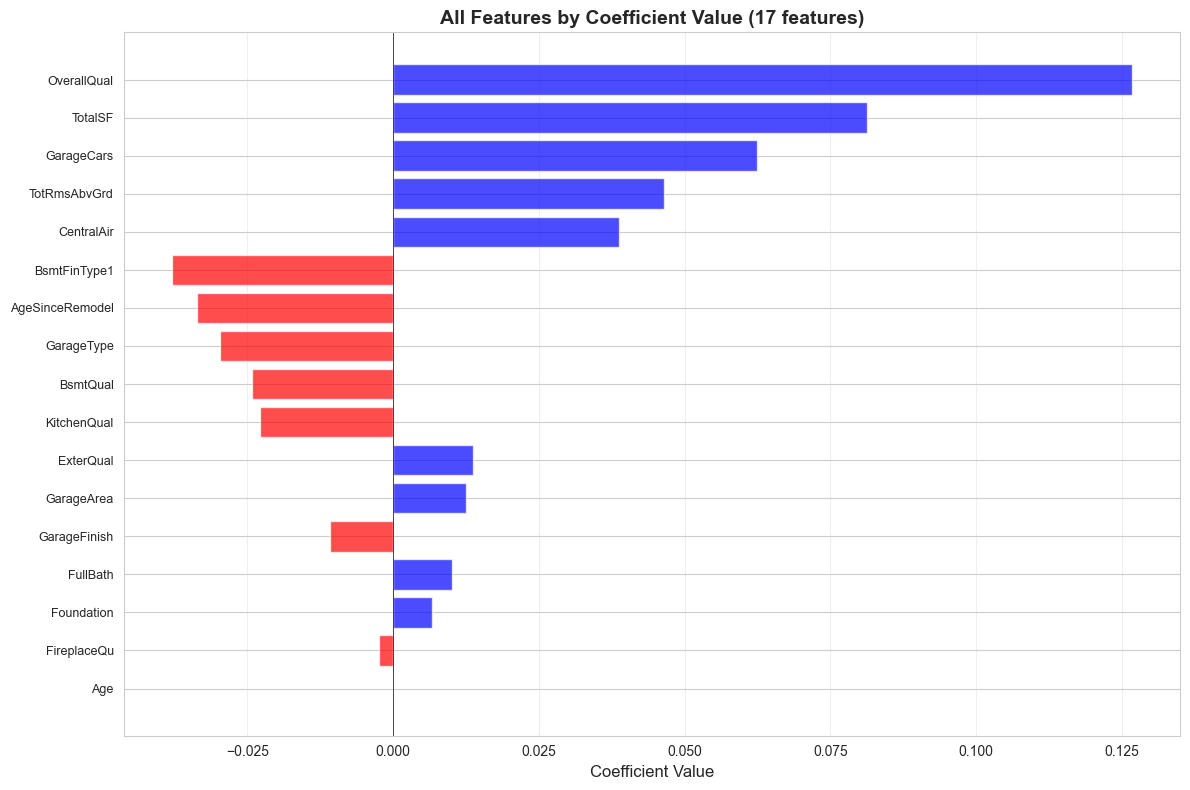


Total features in model: 17

Interpretation:
- Positive coefficients (blue): Feature increases predicted price
- Negative coefficients (red): Feature decreases predicted price
- Larger absolute values indicate stronger influence
- Features sorted by absolute coefficient magnitude (strongest at top)


In [112]:
# Visualize all features by coefficient value
# Sort by absolute coefficient for better visualization (strongest at top)
all_features_sorted = coef_df.sort_values('Abs_Coefficient', ascending=True)

# Adjust figure height based on number of features
n_features = len(all_features_sorted)
fig_height = max(8, n_features * 0.3)

fig, ax = plt.subplots(figsize=(12, fig_height))
colors = ['red' if x < 0 else 'blue' for x in all_features_sorted['Coefficient']]
ax.barh(range(len(all_features_sorted)), all_features_sorted['Coefficient'], color=colors, alpha=0.7)
ax.set_yticks(range(len(all_features_sorted)))
ax.set_yticklabels(all_features_sorted['Feature'], fontsize=9)
ax.set_xlabel('Coefficient Value', fontsize=12)
ax.set_title(f'All Features by Coefficient Value ({n_features} features)', fontsize=14, fontweight='bold')
ax.axvline(x=0, color='black', linestyle='-', linewidth=0.5)
ax.grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

print(f"\nTotal features in model: {len(all_features_sorted)}")
print("\nInterpretation:")
print("- Positive coefficients (blue): Feature increases predicted price")
print("- Negative coefficients (red): Feature decreases predicted price")
print("- Larger absolute values indicate stronger influence")
print("- Features sorted by absolute coefficient magnitude (strongest at top)")


## 7. Summary and Conclusion


In [113]:
# Model summary
print("=" * 80)
print("MODEL SUMMARY")
print("=" * 80)

print(f"\nModel Type: Multiple Linear Regression")
print(f"Number of features: {X_train.shape[1]}")
print(f"Training samples: {len(X_train)}")
print(f"Validation samples: {len(X_val)}")
print(f"Test samples: {len(X_test)}")

print(f"\nPerformance Summary:")
print("-" * 80)
print(f"Training RMSE:   {rmse_train:.6f}")
print(f"Validation RMSE: {rmse_val:.6f}")
print(f"Training R²:     {r2_train:.6f}")
print(f"Validation R²:   {r2_val:.6f}")

# Model assessment
print(f"\nModel Assessment:")
print("-" * 80)
if r2_val > 0.8:
    print("✓ Excellent model performance (R² > 0.8)")
elif r2_val > 0.6:
    print("✓ Good model performance (R² > 0.6)")
elif r2_val > 0.4:
    print("⚠ Moderate model performance (R² > 0.4)")
else:
    print("⚠ Poor model performance (R² < 0.4)")

if abs(rmse_val - rmse_train) < 0.05:
    print("✓ Model shows good generalization (no overfitting)")
else:
    print("⚠ Potential overfitting detected (large gap between train and validation RMSE)")

print(f"\nNext Steps:")
print("-" * 80)
print("1. Consider feature engineering to improve model performance")
print("2. Try regularization (Ridge, Lasso) to reduce overfitting if present")
print("3. Explore non-linear models (polynomial regression, tree-based models)")
print("4. Evaluate on test set (only after final model selection)")
print("5. Consider ensemble methods for better performance")

print("\n" + "=" * 80)
print("✓ Multiple Linear Regression Model Training Complete!")
print("=" * 80)


MODEL SUMMARY

Model Type: Multiple Linear Regression
Number of features: 17
Training samples: 876
Validation samples: 292
Test samples: 292

Performance Summary:
--------------------------------------------------------------------------------
Training RMSE:   0.160061
Validation RMSE: 0.158748
Training R²:     0.831393
Validation R²:   0.836267

Model Assessment:
--------------------------------------------------------------------------------
✓ Excellent model performance (R² > 0.8)
✓ Model shows good generalization (no overfitting)

Next Steps:
--------------------------------------------------------------------------------
1. Consider feature engineering to improve model performance
2. Try regularization (Ridge, Lasso) to reduce overfitting if present
3. Explore non-linear models (polynomial regression, tree-based models)
4. Evaluate on test set (only after final model selection)
5. Consider ensemble methods for better performance

✓ Multiple Linear Regression Model Training Complet